In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define the directory path
data_dir = r'C:\Users\velur\Downloads\dataset2-master\dataset2-master\images\TRAIN'

In [3]:
# Define the class labels
class_labels = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

# Initialize lists to hold file paths and labels
filepaths = []
labels = []

# Loop through each class directory and gather file paths and labels
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    for file in os.listdir(class_dir):
        if file.endswith('.jpeg') or file.endswith('.png'):  # Ensure file is an image
            filepaths.append(os.path.join(class_dir, file))
            labels.append(label)

# Create a DataFrame from the file paths and labels
bloodCell_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Shuffle the DataFrame
bloodCell_df = bloodCell_df.sample(frac=1).reset_index(drop=True)

In [4]:
# Display the first few rows
bloodCell_df.head()

,filepaths,labels
0,C:\Users\velur\Downloads\dataset2-master\datas...,neutrophil
1,C:\Users\velur\Downloads\dataset2-master\datas...,eosinophil
2,C:\Users\velur\Downloads\dataset2-master\datas...,neutrophil
3,C:\Users\velur\Downloads\dataset2-master\datas...,eosinophil
4,C:\Users\velur\Downloads\dataset2-master\datas...,monocyte


In [5]:
from sklearn.model_selection import train_test_split

# Now this will work
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape) 
print(val_set.shape)
print(train_images.shape)

(5575, 2)
(2988, 2)
(1394, 2)
(6969, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(244, 244), 
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=8,
                                      shuffle=False
                                     )

test = image_gen.flow_from_dataframe(dataframe=test_images, x_col="filepaths", y_col="labels",
                                     target_size=(244, 244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle=False
                                    )

val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(244, 244),
                                    color_mode='rgb', 
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 5575 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1394 validated image filenames belonging to 4 classes.


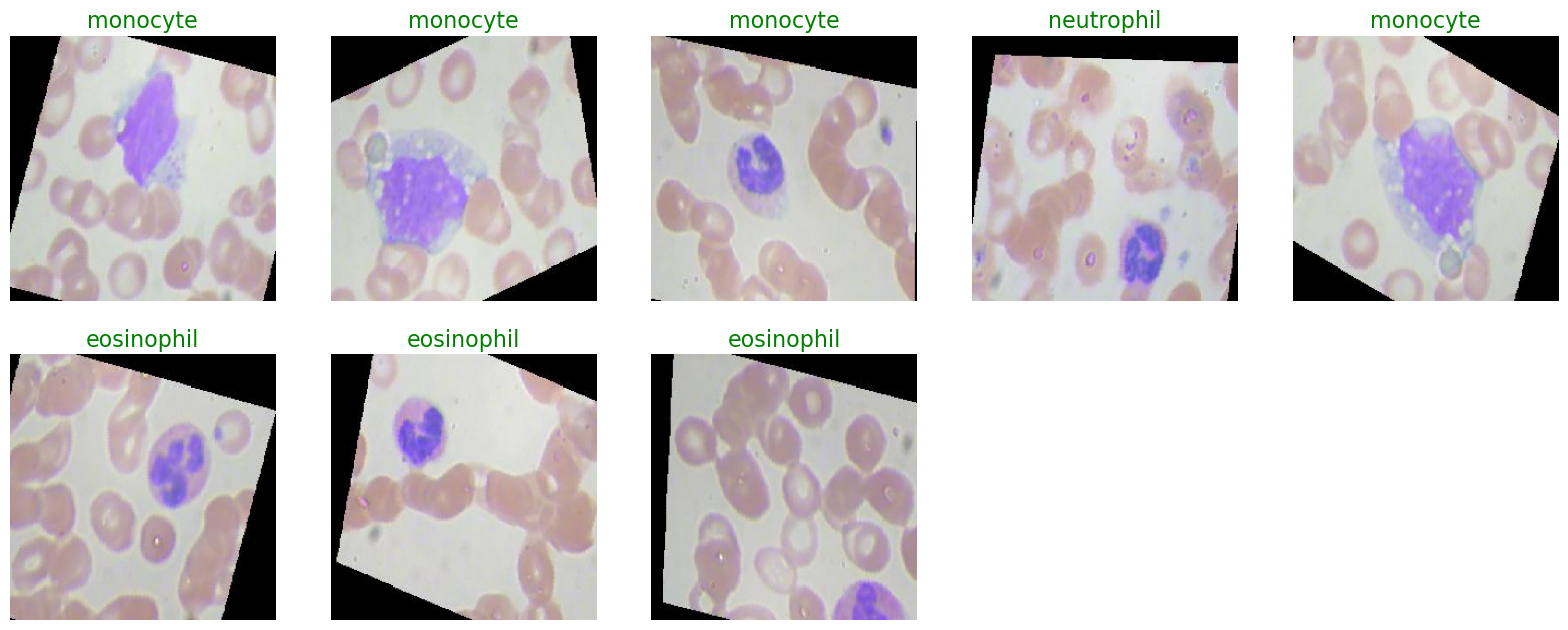

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_knee_images(image_gen):
    test_dict = image_gen.class_indices 
    classes = list(test_dict.keys()) 
    images, labels = next(image_gen)

    plt.figure(figsize=(20, 20)) 
    length = len(labels) 
    
    if length < 25:
        r = length
    else:
        r = 25

    for i in range(r):
        plt.subplot(5, 5, i+1)
        image = (images[i] + 1) / 2
        plt.imshow(image)

        index = np.argmax(labels[i])
        class_name = classes[index]

        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')

    plt.show()

# Show sample images from training data
show_knee_images(train)

In [9]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

C:\Users\velur\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [10]:
history = model.fit(train, epochs=5, validation_data=val, verbose=1)

C:\Users\velur\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 4461s 6s/step - accuracy: 0.2825 - loss: 2.1187 - val_accuracy: 0.5301 - val_loss: 1.0726
Epoch 2/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 4456s 6s/step - accuracy: 0.4650 - loss: 1.2514 - val_accuracy: 0.6205 - val_loss: 0.8920
Epoch 3/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 4293s 6s/step - accuracy: 0.5845 - loss: 0.9966 - val_accuracy: 0.7260 - val_loss: 0.6537
Epoch 4/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 4410s 6s/step - accuracy: 0.6763 - loss: 0.7642 - val_accuracy: 0.5940 - val_loss: 0.9812
Epoch 5/5
697/697 ━━━━━━━━━━━━━━━━━━━━ 4312s 6s/step - accuracy: 0.7571 - loss: 0.5877 - val_accuracy: 0.8286 - val_loss: 0.4137


In [11]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

697/697 ━━━━━━━━━━━━━━━━━━━━ 4495s 6s/step - accuracy: 0.8132 - loss: 0.4379 - val_accuracy: 0.8250 - val_loss: 0.4089


In [38]:
model.save("Blood Cell.h5")

In [33]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items()) 
pred2 = [labels[k] for k in pred]

374/374 ━━━━━━━━━━━━━━━━━━━━ 637s 2s/step


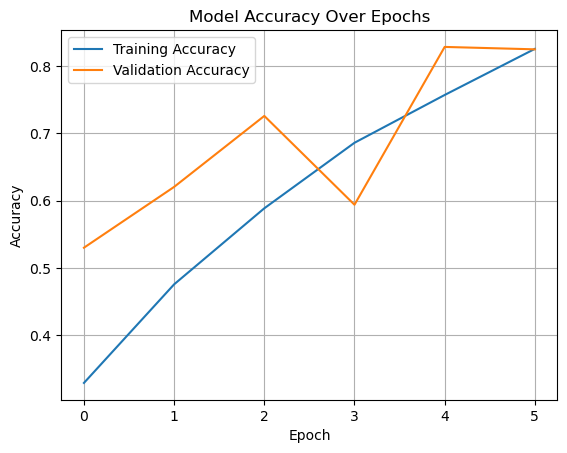

In [34]:
# Combine accuracies from history and history1
train_acc = history.history['accuracy'] + history1.history['accuracy']
val_acc = history.history['val_accuracy'] + history1.history['val_accuracy']

# Plot
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

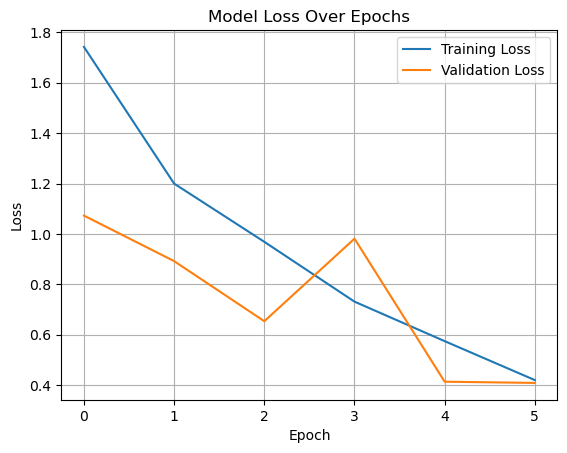

In [35]:
train_loss = history.history['loss'] + history1.history['loss']
val_loss = history.history['val_loss'] + history1.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import classification_report
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score (y_test, pred2)*100))

              precision    recall  f1-score   support

  eosinophil       0.65      0.78      0.71       731
  lymphocyte       0.79      1.00      0.88       741
    monocyte       0.97      0.98      0.98       760
  neutrophil       0.90      0.49      0.64       756

    accuracy                           0.81      2988
   macro avg       0.83      0.81      0.80      2988
weighted avg       0.83      0.81      0.80      2988

Accuracy of the Model: 81.2%


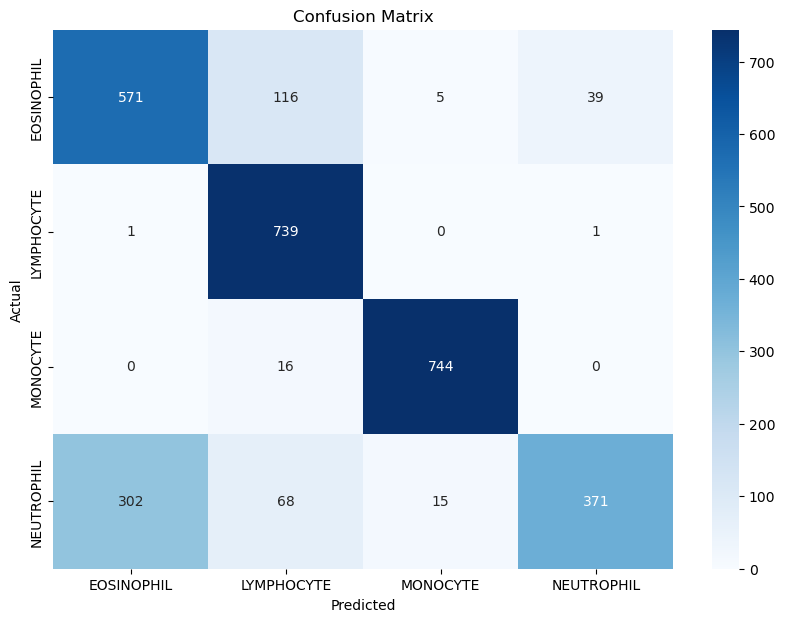

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Class labels
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Confusion matrix
cm = confusion_matrix(y_test, pred2)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
